In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [31]:
extracted_features = np.load("separate_features.npz")
# Create a dictionary from the loaded features, handling multi-dimensional arrays
data = {}
for key in extracted_features.files:
    arr = extracted_features[key]
    if arr.ndim > 1:
        # If the array is multi-dimensional, create multiple columns
        for i in range(arr.shape[1]):
            data[f'{key}_{i+1}'] = arr[:, i]
    else:
        # If the array is 1-dimensional, use it directly
        data[key] = arr

X = pd.DataFrame(data)

In [42]:
list(data.keys())

['aa_comp_1',
 'aa_comp_2',
 'aa_comp_3',
 'aa_comp_4',
 'aa_comp_5',
 'aa_comp_6',
 'aa_comp_7',
 'aa_comp_8',
 'aa_comp_9',
 'aa_comp_10',
 'aa_comp_11',
 'aa_comp_12',
 'aa_comp_13',
 'aa_comp_14',
 'aa_comp_15',
 'aa_comp_16',
 'aa_comp_17',
 'aa_comp_18',
 'aa_comp_19',
 'aa_comp_20',
 'hydrophobicity_1',
 'hydrophobicity_2',
 'hydrophobicity_3',
 'net_charge_1',
 'net_charge_2',
 'net_charge_3',
 'hydrophilicity_1',
 'hydrophilicity_2',
 'hydrophilicity_3',
 'helix_propensity_1',
 'helix_propensity_2',
 'helix_propensity_3',
 'flexibility_1',
 'flexibility_2',
 'flexibility_3',
 'isoelectric_point_1',
 'isoelectric_point_2',
 'isoelectric_point_3',
 'bulkiness_1',
 'bulkiness_2',
 'bulkiness_3']

In [32]:
cols = ["id", "organism_name", "kingdom","seq_len","SP","validation_n", "sp_type"]
training_df = pd.read_csv("training_set.tsv", sep="\t", names= cols)

y =training_df['sp_type']
X.head()


,aa_comp_1,aa_comp_2,aa_comp_3,aa_comp_4,aa_comp_5,aa_comp_6,aa_comp_7,aa_comp_8,aa_comp_9,aa_comp_10,...,helix_propensity_3,flexibility_1,flexibility_2,flexibility_3,isoelectric_point_1,isoelectric_point_2,isoelectric_point_3,bulkiness_1,bulkiness_2,bulkiness_3
0,0.182,0.000,0.0,0.000,0.136,0.091,0.000,0.000,0.0,0.000,...,1.333,0.410,0.046,0.499,5.844,0.744,9.163,15.949,2.369,20.414
1,0.045,0.000,0.0,0.045,0.091,0.000,0.000,0.091,0.0,0.000,...,1.354,0.427,0.043,0.512,5.919,0.862,8.487,14.830,2.777,18.876
2,0.182,0.045,0.0,0.000,0.000,0.000,0.000,0.045,0.0,0.045,...,1.223,0.411,0.029,0.469,6.202,0.890,9.167,16.859,0.937,18.960
3,0.091,0.045,0.0,0.000,0.045,0.000,0.000,0.000,0.0,0.045,...,1.209,0.410,0.027,0.488,6.171,1.044,9.000,16.351,2.594,20.339
4,0.136,0.000,0.0,0.000,0.045,0.000,0.045,0.091,0.0,0.045,...,1.159,0.403,0.026,0.458,5.952,0.680,8.593,16.017,2.508,20.644


In [33]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (4812, 41)
Validation set shape: (1604, 41)
Test set shape: (1605, 41)


In [34]:
# We'll use a simple StandardScaler + RBF SVM pipeline
def svm_pipeline(C, gamma):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=42))
    ])

# Minimal manual grid
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

best_score_base = -np.inf
best_params_base = None

for C in C_grid:
    for gamma in gamma_grid:
        pipe = svm_pipeline(C, gamma)
        pipe.fit(X_train, y_train)                 # fit on TRAIN
        val_acc = pipe.score(X_val, y_val)         # evaluate on VALIDATION
        if val_acc > best_score_base:
            best_score_base = val_acc
            best_params_base = {"C": C, "gamma": gamma}

print("Baseline SVM (all features) — best validation accuracy: "
      f"{best_score_base:.3f} with params {best_params_base}")

Baseline SVM (all features) — best validation accuracy: 0.968 with params {'C': 10.0, 'gamma': 0.01}


Top 10 features by Gini importance:
              feature  importance
0    hydrophilicity_1    0.137997
1       flexibility_1    0.098751
2    hydrophobicity_3    0.097708
3    hydrophobicity_1    0.081997
4         bulkiness_3    0.070742
5          aa_comp_11    0.063506
6    hydrophobicity_2    0.047473
7  helix_propensity_1    0.034352
8  helix_propensity_2    0.033800
9         bulkiness_2    0.031544


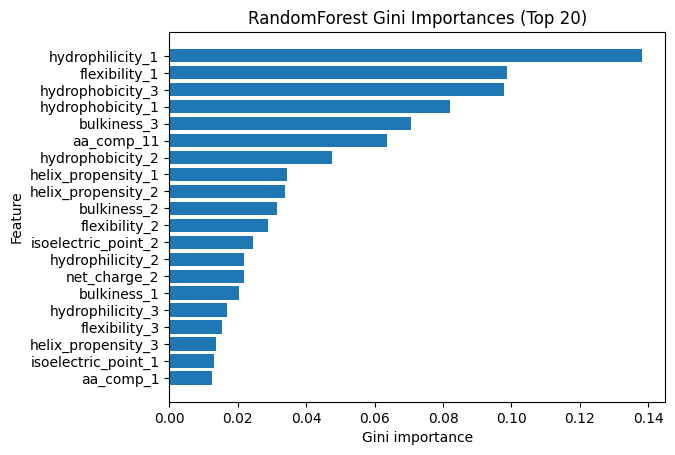

In [44]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)  # fit only on TRAIN

gini_imp = pd.Series(rf.feature_importances_, index=list(data.keys())).sort_values(ascending=False)
gini_df = gini_imp.reset_index()
gini_df.columns = ["feature", "importance"]
print("Top 10 features by Gini importance:")
print(gini_df.head(10))

# Plot top 20
plt.figure()
plt.barh(gini_df["feature"].head(20)[::-1], gini_df["importance"].head(20)[::-1])
plt.xlabel("Gini importance")
plt.ylabel("Feature")
plt.title("RandomForest Gini Importances (Top 20)")
plt.savefig("gini_rf.png")
plt.show()

Best k on validation (using baseline best params): k=25, val_acc=0.969


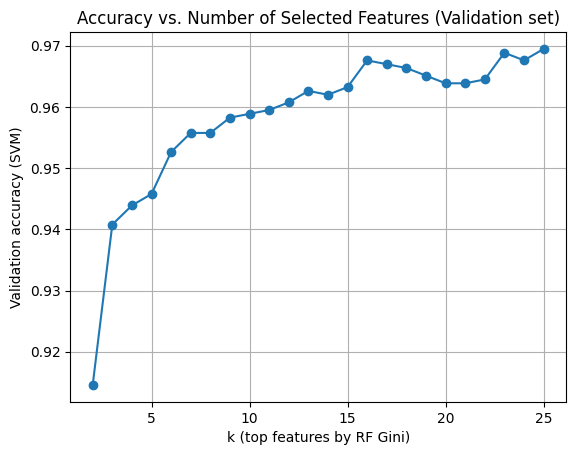

In [49]:
def accuracy_on_subset(C, gamma, subset_features):
    # subset by feature names
    # Convert data keys to a NumPy array for use with np.where
    data_keys_np = np.array(list(data.keys()))
    idx = [np.where(data_keys_np == f)[0][0] for f in subset_features]
    Xtr = X_train.iloc[:, idx]
    Xva = X_val.iloc[:, idx]
    pipe = svm_pipeline(C, gamma)
    pipe.fit(Xtr, y_train)     # train on TRAIN only
    return pipe.score(Xva, y_val)  # accuracy on VALIDATION

# We'll sweep k and, for each k, re-evaluate the best baseline SVM params on the reduced feature set
ks = list(range(2, min(26, X_train.shape[1]+1)))  # keep it small for speed/clarity
curve = []

for k in ks:
    subset = gini_df["feature"].head(k).tolist()
    acc_k = accuracy_on_subset(best_params_base["C"], best_params_base["gamma"], subset)
    curve.append(acc_k)

best_k_idx = int(np.argmax(curve))
best_k = ks[best_k_idx]
print(f"Best k on validation (using baseline best params): k={best_k}, val_acc={curve[best_k_idx]:.3f}")

plt.figure()
plt.plot(ks, curve, marker="o")
plt.xlabel("k (top features by RF Gini)")
plt.ylabel("Validation accuracy (SVM)")
plt.title("Accuracy vs. Number of Selected Features (Validation set)")
plt.grid(True)
plt.savefig("accuracy_vs_k.png")
plt.show()

In [51]:
# Use the best k from the validation curve
best_subset = gini_df["feature"].head(best_k).tolist()
data_keys_np = np.array(list(data.keys()))
idx = [np.where(data_keys_np == f)[0][0] for f in best_subset]

Xtr_sel = X_train.iloc[:, idx]
Xva_sel = X_val.iloc[:, idx]
Xte_sel = X_test.iloc[:, idx]

# Manual grid search again but now restricted to the selected features
best_score_sel = -np.inf
best_params_sel = None

for C in C_grid:
    for gamma in gamma_grid:
        pipe = svm_pipeline(C, gamma)
        pipe.fit(Xtr_sel, y_train)      # train on TRAIN
        val_acc = pipe.score(Xva_sel, y_val)  # validate on VAL
        if val_acc > best_score_sel:
            best_score_sel = val_acc
            best_params_sel = {"C": C, "gamma": gamma}

# Train final model on TRAIN+VAL with best params (optional) or just TRAIN; here we keep TRAIN only as per your outline
final_pipe = svm_pipeline(best_params_sel["C"], best_params_sel["gamma"])
final_pipe.fit(Xtr_sel, y_train)
test_acc = final_pipe.score(Xte_sel, y_test)


print("Selected features (best k):", best_subset)
print("Best validation accuracy on selected features:", f"{best_score_sel:.3f}", "with", best_params_sel)
print("Test accuracy (selected features, tuned on val):", f"{test_acc:.3f}")

# For comparison: test accuracy with all features using baseline best params
baseline_pipe = svm_pipeline(best_params_base["C"], best_params_base["gamma"])
baseline_pipe.fit(X_train, y_train)
test_acc_all = baseline_pipe.score(X_test, y_test)
print("Test accuracy (all features, baseline tuned on val):", f"{test_acc_all:.3f}")

Selected features (best k): ['hydrophilicity_1', 'flexibility_1', 'hydrophobicity_3', 'hydrophobicity_1', 'bulkiness_3', 'aa_comp_11', 'hydrophobicity_2', 'helix_propensity_1', 'helix_propensity_2', 'bulkiness_2', 'flexibility_2', 'isoelectric_point_2', 'hydrophilicity_2', 'net_charge_2', 'bulkiness_1', 'hydrophilicity_3', 'flexibility_3', 'helix_propensity_3', 'isoelectric_point_1', 'aa_comp_1', 'isoelectric_point_3', 'net_charge_1', 'aa_comp_4', 'aa_comp_3', 'aa_comp_8']
Best validation accuracy on selected features: 0.970 with {'C': 1.0, 'gamma': 'scale'}
Test accuracy (selected features, tuned on val): 0.980
Test accuracy (all features, baseline tuned on val): 0.981


L’analisi di feature importance mediante Random Forest ha permesso di selezionare circa 25 feature più rilevanti, tra cui hydrophilicity_1, flexibility_1 e hydrophobicity_3.
Utilizzando tali feature in un modello SVM con kernel RBF, l’accuratezza in validazione e test (0.970 e 0.980) risulta praticamente identica al modello completo (0.981), dimostrando che le feature rimanenti sono ridondanti o poco informative.
Questo conferma l’efficacia della selezione embedded nel migliorare la semplicità e l’interpretabilità del modello senza comprometterne le prestazioni.